<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/dynamicsimul.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install neqsim

#Dynamic process calculations using NeqSim

In the following examples we will give examples of how neqsim can be used for dynamic process simulations. In the following example we regulate the flow of gas via a valve.

It sets up a system with a fluid, a stream, valves, and a separator. It also includes a flow transmitter and a controller to regulate the feed flow via a valve. The simulation then runs through different scenarios, adjusting setpoints and valve openings to observe the system's response over time. Finally, it plots the results of the simulation, showing how variables like valve opening, flow, and pressure change over time.



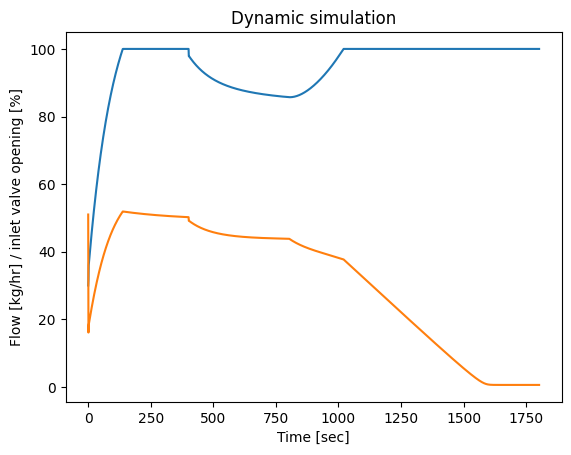

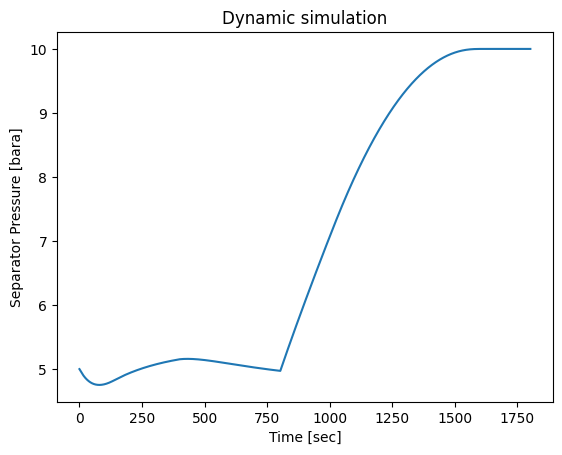

In [2]:
import neqsim
from neqsim import jneqsim

import matplotlib.pyplot as plt

fluid1 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("ethane", 0.100)
fluid1.addComponent("n-heptane", 1.00)
fluid1.setMixingRule('classic')

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", fluid1)
stream1.setFlowRate(51.0, "kg/hr")
stream1.setPressure(10.0, "bara")

valve1 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1)
valve1.setOutletPressure(5.0)
initialvalveopening = 30
valve1.setPercentValveOpening(initialvalveopening)

separator1 =  jneqsim.process.equipment.separator.Separator("sep 1")
separator1.addStream(valve1.getOutletStream())
separator1.setSeparatorLength(0.3);
separator1.setInternalDiameter(1.0);
separator1.setLiquidLevel(.5);

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream())
valve2.setOutletPressure(1.0)
valve2.setPercentValveOpening(90)

valve3 = jneqsim.process.equipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream())
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(90)

flowTransmitter = jneqsim.process.measurementdevice.VolumeFlowTransmitter(stream1)
flowTransmitter.setUnit("kg/hr")
flowTransmitter.setMaximumValue(100.0)
flowTransmitter.setMinimumValue(1.0)

flowController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
flowController.setTransmitter(flowTransmitter)
flowController.setReverseActing(True)
flowController.setControllerSetPoint(63.5)
#Settin Kp, Ti, Td of PID regulator
flowController.setControllerParameters(0.1, 5.0, 0.0)

p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1)
p.add(valve1)
p.add(separator1)
p.add(valve2)
p.add(valve3)
p.add(flowTransmitter)
valve1.setController(flowController)
separator1.setCalculateSteadyState(False)
valve1.setCalculateSteadyState(False)
valve2.setCalculateSteadyState(False)
valve3.setCalculateSteadyState(False)

p.run();

time = []
valveopening = []
separator_pressure = []
flow = []

p.setTimeStep(1);
for i in range(401):
  time.append(p.getTime())
  valveopening.append(valve1.getPercentValveOpening())
  flow.append(flowTransmitter.getMeasuredValue())
  separator_pressure.append(separator1.getGasOutStream().getPressure())
  #print("volume flow ", flowTransmitter.getMeasuredValue(), " valve opening ", valve1.getPercentValveOpening(), " pressure ", separator1.getGasOutStream().getPressure())
  p.runTransient()

flowController.setControllerSetPoint(43.5)
for i in range(401):
  time.append(p.getTime())
  valveopening.append(valve1.getPercentValveOpening())
  flow.append(flowTransmitter.getMeasuredValue())
  separator_pressure.append(separator1.getGasOutStream().getPressure())
  #print("volume flow ", flowTransmitter.getMeasuredValue(), " valve opening ", valve1.getPercentValveOpening(), " pressure ", separator1.getGasOutStream().getPressure())
  p.runTransient()

#Cloasing outlet valves
valve2.setPercentValveOpening(0.5)
valve3.setPercentValveOpening(0.5)
p.setTimeStep(0.5);
for i in range(2000):
  time.append(p.getTime())
  valveopening.append(valve1.getPercentValveOpening())
  flow.append(flowTransmitter.getMeasuredValue())
  separator_pressure.append(separator1.getGasOutStream().getPressure())
  #print("volume flow ", flowTransmitter.getMeasuredValue(), " valve opening ", valve1.getPercentValveOpening(), " pressure ", separator1.getGasOutStream().getPressure())
  p.runTransient()

plt.plot(time, valveopening)
plt.plot(time, flow)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Flow [kg/hr] / inlet valve opening [%]")
plt.show()

plt.plot(time, separator_pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Separator Pressure [bara]")
plt.show()

#Controlling pressure and liquid level in separator
In this example we establish a process where a liquid and gas are produced to a separator, and we try to control pressure and liquid level in the separator. We will add a PI/PID regluator to the liquid controll valve and a PD regulator to the valve regulating the pressure in the separator. We will add some perturbations to see how the process reacts.

We start with a steady state solution with a liquid level of 50% in the tank. The we set the the level controller to 45%. A PI regulator with Kp = 0.1 and Ti=5.0 regulates the valve controlling liquid flow from the tank.

After some time we set the level controller to 55%. After further some time we set the pressure controller regulating the gas outlet valve to go from 7 bara to 6 bara in the separator.

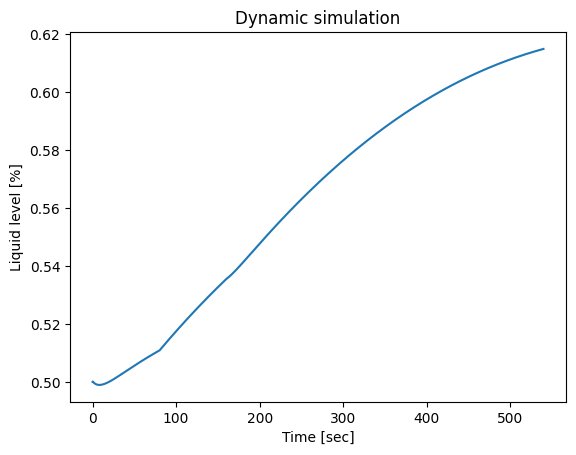

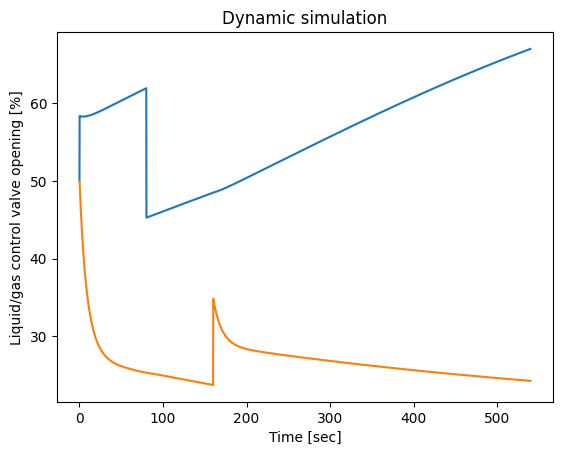

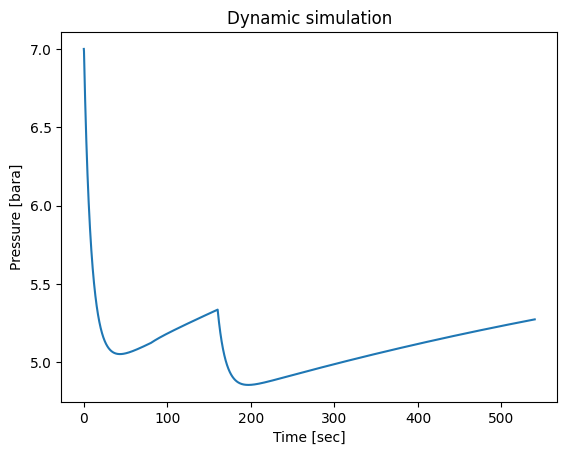

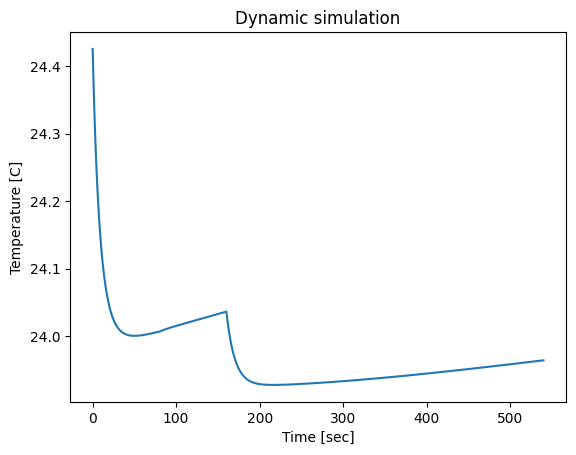

In [3]:
import neqsim
from neqsim import jneqsim

import matplotlib.pyplot as plt

fluid1 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("n-heptane", 1.00)
fluid1.setMixingRule('classic')

fluid2 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
fluid2.addComponent("methane", 1.1)
fluid2.addComponent("n-heptane", 1.001)
fluid2.setMixingRule(2)

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", fluid1);
stream1.setCalculateSteadyState(True);
stream1.setFlowRate(100.0, 'kg/hr')

valve1 = jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(7.0);
valve1.setPercentValveOpening(50);
valve1.setCalculateSteadyState(False)

purgeStream = jneqsim.process.equipment.stream.Stream("Purge Stream", fluid2);
purgeStream.setFlowRate(1.0, 'kg/hr')

purgeValve = jneqsim.process.equipment.valve.ThrottlingValve("purgeValve", purgeStream);
purgeValve.setOutletPressure(7.0);
purgeValve.setPercentValveOpening(50.0);
purgeValve.setCalculateSteadyState(False)

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream())
separator1.addStream(purgeValve.getOutletStream())
separator1.setCalculateSteadyState(False)
separator1.setSeparatorLength(1.0)
separator1.setInternalDiameter(0.2)
separator1.setLiquidLevel(0.5)

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream());
valve2.setOutletPressure(1.0)
valve2.setPercentValveOpening(50)
valve2.setCalculateSteadyState(False)
valve2.setMinimumValveOpening(1.0)
#valve2.setCv(3.9)

valve3 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream());
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(50)
valve3.setCalculateSteadyState(False)
valve3.setMinimumValveOpening(1.0)
valve3.setCv(10.0)

separatorLevelTransmitter = jneqsim.process.measurementdevice.LevelTransmitter(separator1);
separatorLevelTransmitter.setName("separatorLevelTransmitter1");
separatorLevelTransmitter.setMaximumValue(0.8);
separatorLevelTransmitter.setMinimumValue(0.2);

separatorLevelController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
separatorLevelController.setReverseActing(False)
separatorLevelController.setTransmitter(separatorLevelTransmitter)
separatorLevelController.setControllerSetPoint(0.45)
separatorLevelController.setControllerParameters(1, 400.0, 0.0)

separatorPressureTransmitter = jneqsim.process.measurementdevice.PressureTransmitter(separator1.getGasOutStream());
separatorPressureTransmitter.setUnit("bar")
separatorPressureTransmitter.setMaximumValue(10.0)
separatorPressureTransmitter.setMinimumValue(1.0)

separatorPressureController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
separatorPressureController.setTransmitter(separatorPressureTransmitter)
separatorPressureController.setReverseActing(False)
separatorPressureController.setControllerSetPoint(7.0)
separatorPressureController.setControllerParameters(1, 400, 0.0)



p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(purgeStream);
p.add(purgeValve);
p.add(separator1);
p.add(valve2);
p.add(valve3);
p.add(separatorLevelTransmitter);
valve2.setController(separatorLevelController);
p.add(separatorPressureTransmitter);
valve3.setController(separatorPressureController);

p.run();

time = []
pressure = []
temperature = []
level = []
liquidvalveopening = []
gasvalveopening = []

p.setTimeStep(0.2);
for i in range(400):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  p.runTransient()

separatorLevelController.setControllerSetPoint(0.55)

for i in range(400):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  p.runTransient()

separatorPressureController.setControllerSetPoint(6.0)

for i in range(1900):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  p.runTransient()

#plt.plot(time, pressure)
plt.plot(time, level)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid level [%]")
plt.show()

plt.plot(time, liquidvalveopening)
plt.plot(time, gasvalveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid/gas control valve opening [%]")
plt.show()

plt.plot(time, pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()

#Depressurization of a separator
In the following example we will simulate a sudden stop in production (setting inlet valve position opening to 0.1 %) followed by a fast depressurization of the separator to 2 bara.

We use a PI regulator for the liquid level controll and a PID regulator for the pressure controll.

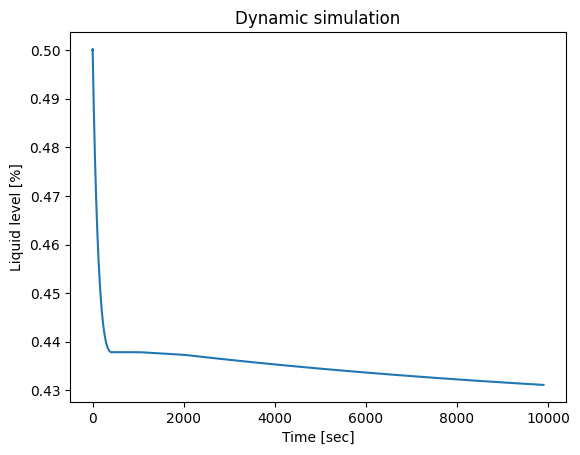

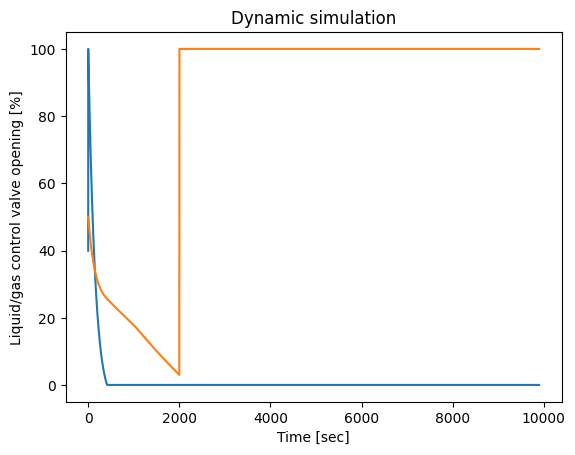

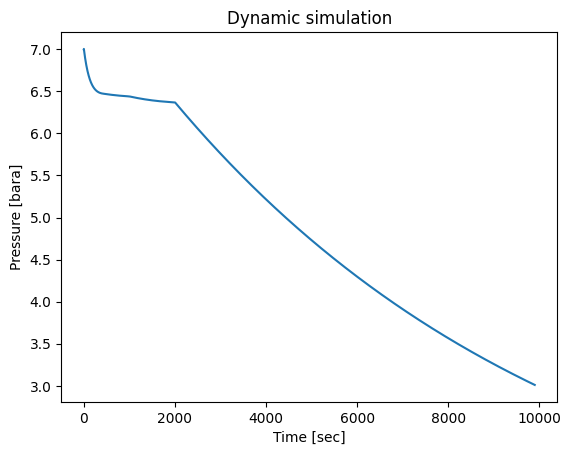

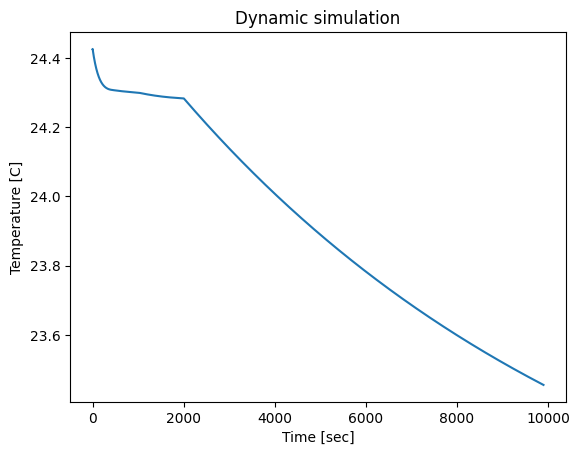

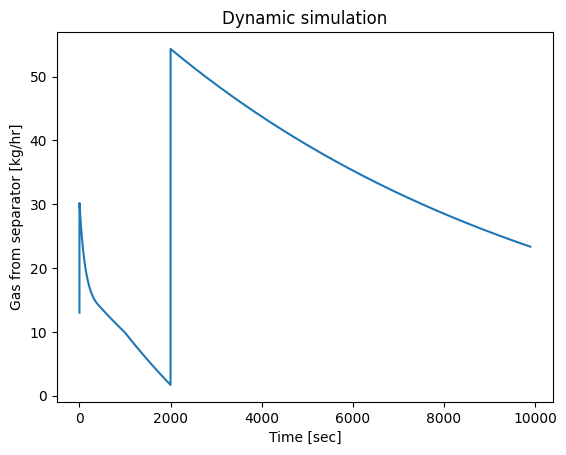

In [4]:
import neqsim
from neqsim import jneqsim

import matplotlib.pyplot as plt

fluid1 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("n-heptane", 1.00)
fluid1.setMixingRule('classic')

fluid2 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00);
fluid2.addComponent("methane", 1.1)
fluid2.addComponent("n-heptane", 1.001)
fluid2.setMixingRule(2)

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", fluid1);
stream1.setCalculateSteadyState(True);
stream1.setFlowRate(100.0, 'kg/hr')

valve1 = jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(7.0);
valve1.setPercentValveOpening(50)
valve1.setMinimumValveOpening(0.1)
valve1.setCalculateSteadyState(False)

purgeStream = jneqsim.process.equipment.stream.Stream("Purge Stream", fluid2);
purgeStream.setFlowRate(1.0, 'kg/hr')

purgeValve = jneqsim.process.equipment.valve.ThrottlingValve("purgeValve", purgeStream);
purgeValve.setOutletPressure(7.0);
purgeValve.setPercentValveOpening(50.0);
purgeValve.setCalculateSteadyState(False)
purgeValve.setMinimumValveOpening(0.1)

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream())
separator1.addStream(purgeValve.getOutletStream())
separator1.setCalculateSteadyState(False)
separator1.setSeparatorLength(10.0)
separator1.setInternalDiameter(2.2)
separator1.setLiquidLevel(0.5)

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream());
valve2.setOutletPressure(1.0)
valve2.setPercentValveOpening(40)
valve2.setCalculateSteadyState(False)
valve2.setMinimumValveOpening(0.1)
valve2.setCv(23.9)

valve3 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream());
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(50)
valve3.setCalculateSteadyState(False)
valve3.setMinimumValveOpening(0.1)
valve3.setCv(12.9)

separatorLevelTransmitter = jneqsim.process.measurementdevice.LevelTransmitter(separator1);
separatorLevelTransmitter.setName("separatorLevelTransmitter1");
separatorLevelTransmitter.setMaximumValue(0.8);
separatorLevelTransmitter.setMinimumValue(0.2);

separatorLevelController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
separatorLevelController.setReverseActing(False)
separatorLevelController.setTransmitter(separatorLevelTransmitter)
separatorLevelController.setControllerSetPoint(0.45)
separatorLevelController.setControllerParameters(10, 500.0, 0.0)

separatorPressureTransmitter = jneqsim.process.measurementdevice.PressureTransmitter(separator1.getGasOutStream());
separatorPressureTransmitter.setUnit("bar")
separatorPressureTransmitter.setMaximumValue(10.0)
separatorPressureTransmitter.setMinimumValue(0.0)

separatorPressureController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
separatorPressureController.setTransmitter(separatorPressureTransmitter)
separatorPressureController.setReverseActing(False)
separatorPressureController.setControllerSetPoint(7.0)
separatorPressureController.setControllerParameters(2, 1000, 1.0)



p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(purgeStream);
p.add(purgeValve);
p.add(separator1);
p.add(valve2);
p.add(valve3);
p.add(separatorLevelTransmitter);
valve2.setController(separatorLevelController);
p.add(separatorPressureTransmitter);
valve3.setController(separatorPressureController);

p.run();

time = []
pressure = []
temperature = []
level = []
liquidvalveopening = []
gasvalveopening = []
gasflowfromsep = []

p.setTimeStep(1);
for i in range(1000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()

#Close inlet valve
valve1.setPercentValveOpening(0.1)
purgeValve.setPercentValveOpening(0.1)

for i in range(1000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()


separatorPressureController.setControllerSetPoint(2.0)

for i in range(7900):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  level.append(separatorLevelTransmitter.getMeasuredValue())
  liquidvalveopening.append(valve2.getPercentValveOpening())
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()


#plt.plot(time, pressure)
plt.plot(time, level)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid level [%]")
plt.show()

plt.plot(time, liquidvalveopening)
plt.plot(time, gasvalveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Liquid/gas control valve opening [%]")
plt.show()

plt.plot(time, pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()

plt.plot(time, gasflowfromsep)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Gas from separator [kg/hr]")
plt.show()

#Depressuration of a gas tank

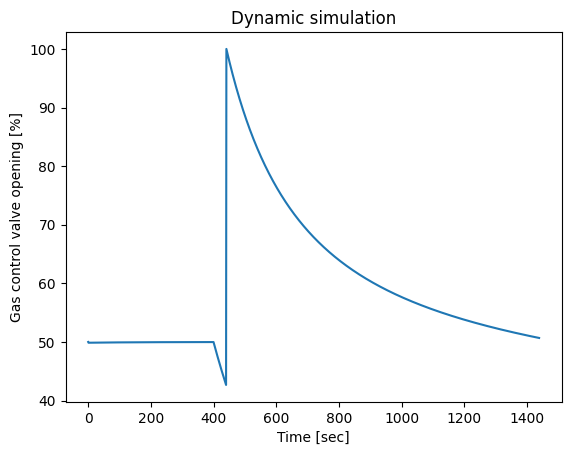

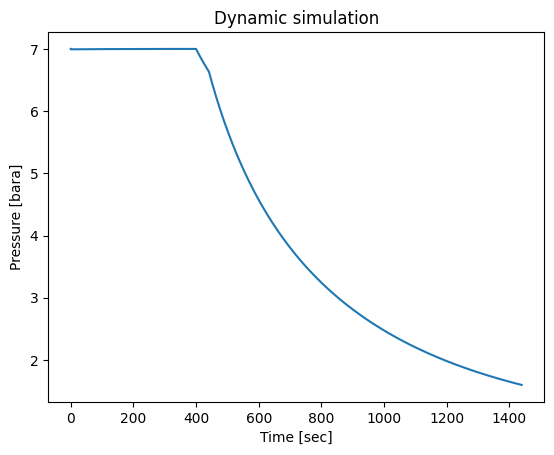

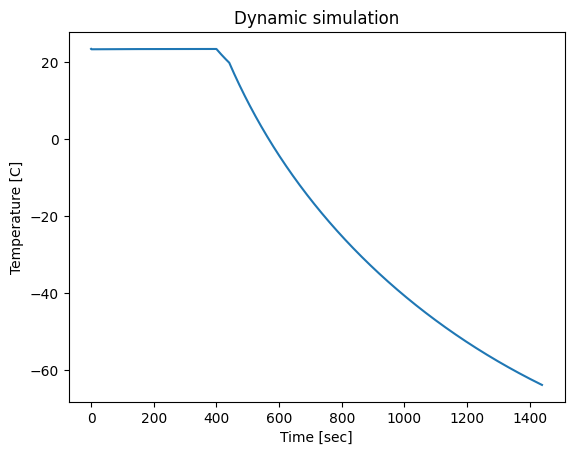

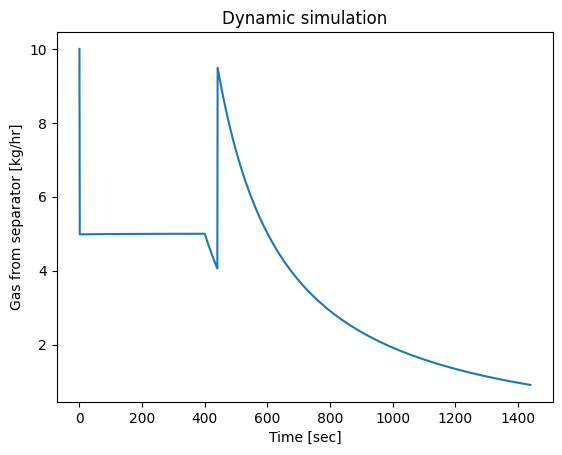

In [ ]:
import neqsim
from neqsim import jneqsim

import matplotlib.pyplot as plt

fluid1 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("ethane", 0.100)
fluid1.setMixingRule('classic')

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", fluid1);
stream1.setCalculateSteadyState(True);
stream1.setFlowRate(10.0, 'kg/hr')

valve1 = jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1);
valve1.setOutletPressure(7.0);
valve1.setPercentValveOpening(50)
valve1.setMinimumValveOpening(0.1)
valve1.setCalculateSteadyState(False)

separator1 = jneqsim.process.equipment.separator.Separator("separator_1");
separator1.addStream(valve1.getOutletStream())
separator1.setCalculateSteadyState(False)
separator1.setSeparatorLength(2.0)
separator1.setInternalDiameter(0.4)
separator1.setLiquidLevel(0.0)

valve3 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream());
valve3.setOutletPressure(1.0)
valve3.setPercentValveOpening(50)
valve3.setCalculateSteadyState(False)
valve3.setMinimumValveOpening(0.1)
#valve2.setCv(5.9)

separatorPressureTransmitter = jneqsim.process.measurementdevice.PressureTransmitter(separator1.getGasOutStream());
separatorPressureTransmitter.setUnit("bar")
separatorPressureTransmitter.setMaximumValue(10.0)
separatorPressureTransmitter.setMinimumValue(0.0)

separatorPressureController = jneqsim.process.controllerdevice.ControllerDeviceBaseClass()
separatorPressureController.setTransmitter(separatorPressureTransmitter)
separatorPressureController.setReverseActing(False)
separatorPressureController.setControllerSetPoint(7.0)
separatorPressureController.setControllerParameters(1, 400.0, 1.0)



p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1);
p.add(valve1);
p.add(separator1);
p.add(valve3);
p.add(separatorPressureTransmitter);
valve3.setController(separatorPressureController);

p.run();

time = []
pressure = []
temperature = []
gasvalveopening = []
gasflowfromsep = []

p.setTimeStep(1);
for i in range(400):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()

#Close inlet valve
valve1.setPercentValveOpening(0.1)

for i in range(40):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()

separatorPressureController.setControllerSetPoint(1.01325)

for i in range(1000):
  time.append(p.getTime())
  pressure.append(separator1.getFluid().getPressure('bara'))
  temperature.append(separator1.getFluid().getTemperature('C'))
  gasvalveopening.append(valve3.getPercentValveOpening())
  gasflowfromsep.append(separator1.getGasOutStream().getFlowRate('kg/hr'))
  p.runTransient()


plt.plot(time, gasvalveopening)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Gas control valve opening [%]")
plt.show()

plt.plot(time, pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()

plt.plot(time, gasflowfromsep)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Gas from separator [kg/hr]")
plt.show()

# Simple pressure releif of a gas tank

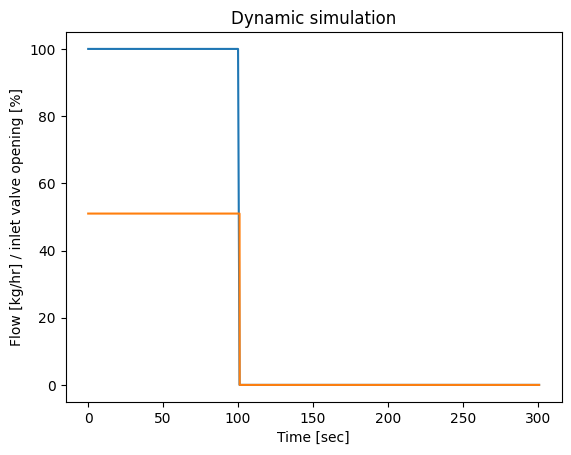

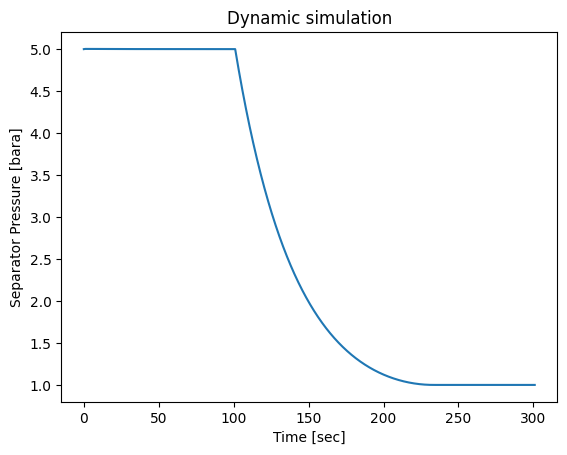

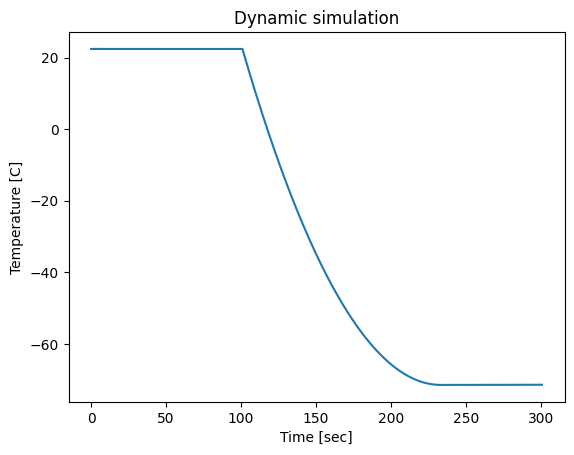

In [12]:
import neqsim
from neqsim import jneqsim

import matplotlib.pyplot as plt

fluid1 = jneqsim.thermo.system.SystemSrkEos((273.15 + 25.0), 10.00)
fluid1.addComponent("methane", 0.900)
fluid1.addComponent("ethane", 0.100)
fluid1.setMixingRule('classic')

stream1 = jneqsim.process.equipment.stream.Stream("Stream1", fluid1)
stream1.setFlowRate(51.0, "kg/hr")
stream1.setPressure(10.0, "bara")

valve1 =  jneqsim.process.equipment.valve.ThrottlingValve("valve_1", stream1)
valve1.setOutletPressure(5.0)

separator1 =  jneqsim.process.equipment.separator.Separator("sep 1")
separator1.addStream(valve1.getOutletStream())
separator1.setSeparatorLength(0.3);
separator1.setInternalDiameter(1.0);
separator1.setLiquidLevel(0.0);

valve2 = jneqsim.process.equipment.valve.ThrottlingValve("valve_2", separator1.getLiquidOutStream())
valve2.setOutletPressure(1.0)

valve3 = jneqsim.process.equipment.valve.ThrottlingValve("valve_3", separator1.getGasOutStream())
valve3.setOutletPressure(1.0)

p = jneqsim.process.processmodel.ProcessSystem()
p.add(stream1)
p.add(valve1)
p.add(separator1)
p.add(valve2)
p.add(valve3)
separator1.setCalculateSteadyState(False)
valve1.setCalculateSteadyState(False)
valve2.setCalculateSteadyState(False)
valve3.setCalculateSteadyState(False)

p.run();

time = []
valveopening = []
separator_pressure = []
flow = []
temperature = []

p.setTimeStep(1);
for i in range(101):
  time.append(p.getTime())
  valveopening.append(valve1.getPercentValveOpening())
  flow.append(valve1.getOutletStream().getFlowRate("kg/hr"))
  separator_pressure.append(separator1.getGasOutStream().getPressure())
  temperature.append(separator1.getFluid().getTemperature('C'))
  #print("volume flow ", flowTransmitter.getMeasuredValue(), " valve opening ", valve1.getPercentValveOpening(), " pressure ", separator1.getGasOutStream().getPressure())
  p.runTransient()

valve1.setPercentValveOpening(0.01)
p.setTimeStep(0.1);
for i in range(2000):
  time.append(p.getTime())
  valveopening.append(valve1.getPercentValveOpening())
  flow.append(valve1.getOutletStream().getFlowRate("kg/hr"))
  separator_pressure.append(separator1.getGasOutStream().getPressure())
  temperature.append(separator1.getFluid().getTemperature('C'))
  #print("volume flow ", flowTransmitter.getMeasuredValue(), " valve opening ", valve1.getPercentValveOpening(), " pressure ", separator1.getGasOutStream().getPressure())
  p.runTransient()

plt.plot(time, valveopening)
plt.plot(time, flow)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Flow [kg/hr] / inlet valve opening [%]")
plt.show()

plt.plot(time, separator_pressure)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Separator Pressure [bara]")
plt.show()

plt.plot(time, temperature)
plt.title("Dynamic simulation")
plt.xlabel("Time [sec]")
plt.ylabel("Temperature [C]")
plt.show()